# Taller 1: AI for Social Sciences
- Francisco Montalvo A - 201631606
- Martin López - 201730955
- María Camila Villalobos - 201820233
- Nicolás Laguna - 201821334

In [2]:
# Primero debemos importar los modulos importantes, no van a ser todos, solo los vitales inicialmente
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 

# 0. Organizar la base

In [3]:
base = pd.read_csv("cancer_mama.csv")
#Hay que organizar las variables de la base entonces se les va a cambiar el nombre.
base= base.rename(columns={"radius ":"radius","texture ":"texture","perimeter ":"perimeter","area ":"area","smoothness ":"smoothness","compactness ":"compactness","concavity ":"concavity","symmetry ":"symmetry","ID number":"idnumber","concave points":"concavepoints","fractal dimension":"fractaldimension"}) #Las variables tenian un espacio alado de su nombre

In [4]:
#Ahora se deben reemplazar los 0 por missing values en la base de datos
cols = ["radius", "texture", "perimeter", "area", "smoothness",
        "compactness", "concavity", "concavepoints", "symmetry", "fractaldimension"]
base[cols] = base[cols].replace({'0': np.nan, 0: np.nan})


# 1. Estadisticas Descriptivas

In [5]:
base.describe()

,idnumber,radius,texture,perimeter,area,smoothness,compactness,concavity,concavepoints,symmetry,fractaldimension
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,556.000000,556.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.090876,0.050063,0.181162,0.062798
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079468,0.038517,0.027414,0.007060
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000692,0.001852,0.106000,0.049960
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.030880,0.020895,0.161900,0.057700
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.064905,0.034840,0.179200,0.061540
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.132325,0.074842,0.195700,0.066120
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


array([[<AxesSubplot:title={'center':'idnumber'}>,
        <AxesSubplot:title={'center':'radius'}>,
        <AxesSubplot:title={'center':'texture'}>],
       [<AxesSubplot:title={'center':'perimeter'}>,
        <AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'smoothness'}>],
       [<AxesSubplot:title={'center':'compactness'}>,
        <AxesSubplot:title={'center':'concavity'}>,
        <AxesSubplot:title={'center':'concavepoints'}>],
       [<AxesSubplot:title={'center':'symmetry'}>,
        <AxesSubplot:title={'center':'fractaldimension'}>,
        <AxesSubplot:>]], dtype=object)

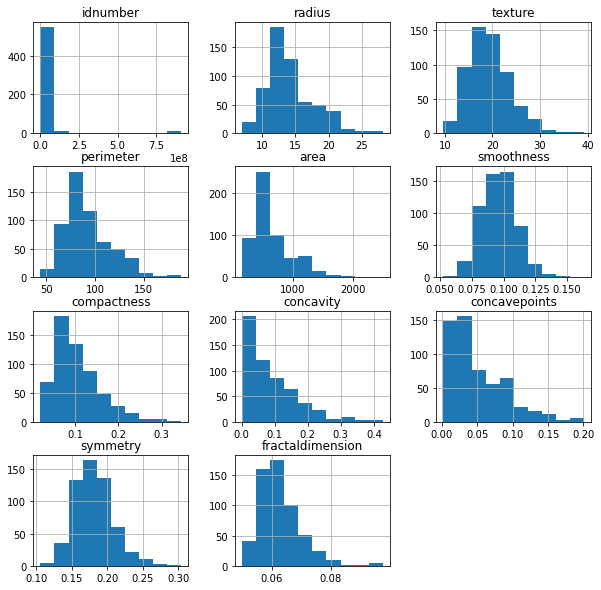

In [6]:
base.hist(column=None, by=None, grid=True, xlabelsize=None, xrot=None,
                   ylabelsize=None, yrot=None, ax=None, sharex=False, sharey=False, 
                   figsize= (10, 10), layout=None, bins=10, backend=None, legend=False)

In [7]:
#Inicialmente se revisa si se repiten observaciones en la base usando idnumber
#Para evitar problemas con id number que tiene un espacio en la mitad se cambia el nombre de la columna

duplicados=base.idnumber.duplicated() #Esto nos va a dar un panda series que tiene valores booleanos de true o false sobre si los individuos estan repetidos

#El siguiente comando revisa si es que hay algun true, queria decir que los valores tienen repetidos
duplicados.any(axis=0, bool_only=None, skipna=True, level=None)



False

- Con base en el resultado anterior podemos concluir que no existen repetidos dado que pidió algún true dentro de la serie y retornó falso, es decir no hay trues

In [8]:
#Dado lo antrior, podemos eliminar la columna idnumber ya que no ayuda a predecir absolutamente nada.

base = base.drop(["idnumber"], axis=1)


In [9]:
#Revisamos Missing Values de diferentes variables para ver si se deben eliminar algunas.

print(100 * base.isna().sum(axis = 0) / base.shape[0]) #Al dividir en base.shape nos va a dar el porcentaje por cada variable

Diagnosis           0.00000
radius              0.00000
texture             0.00000
perimeter           0.00000
area                0.00000
smoothness          0.00000
compactness         0.00000
concavity           2.28471
concavepoints       2.28471
symmetry            0.00000
fractaldimension    0.00000
dtype: float64


In [10]:
print(base.concavity)

0      0.30010
1      0.08690
2      0.19740
3      0.24140
4      0.19800
        ...   
564    0.24390
565    0.14400
566    0.09251
567    0.35140
568        NaN
Name: concavity, Length: 569, dtype: float64


In [11]:
#En este caso no hay que retornar variables explicativas categóricas dado que se tienen variables continuas.
#Hay que convertir diagnosis a una variable categórica que reciba valores de 0 y 1, 1 sería M es decir tiene el tumor, 0 sería B. 
base= base.rename(columns={"Diagnosis ":"diag"})
base[["diag"]] = base[["diag"]].apply(lambda x: x.astype("category"))

base['diag'].replace(['B', 'M'],[0, 1], inplace=True)

<AxesSubplot:ylabel='diag'>

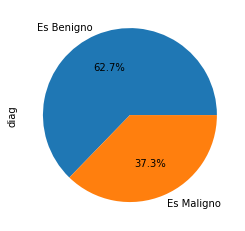

In [12]:
#Se hace un re-encode de los valores que puede tomar la variable diagnosis y se ve su distribución
base.diag.value_counts().rename({0: "Es Benigno", 1: "Es Maligno"}).plot.pie(autopct = "%.1f%%")

- El 62.7% de las personas en la muestra tienen un tumor benigno
- El 37.3% de las personas en la muestra tienen un tumor maligno

## 1b. PairPlots

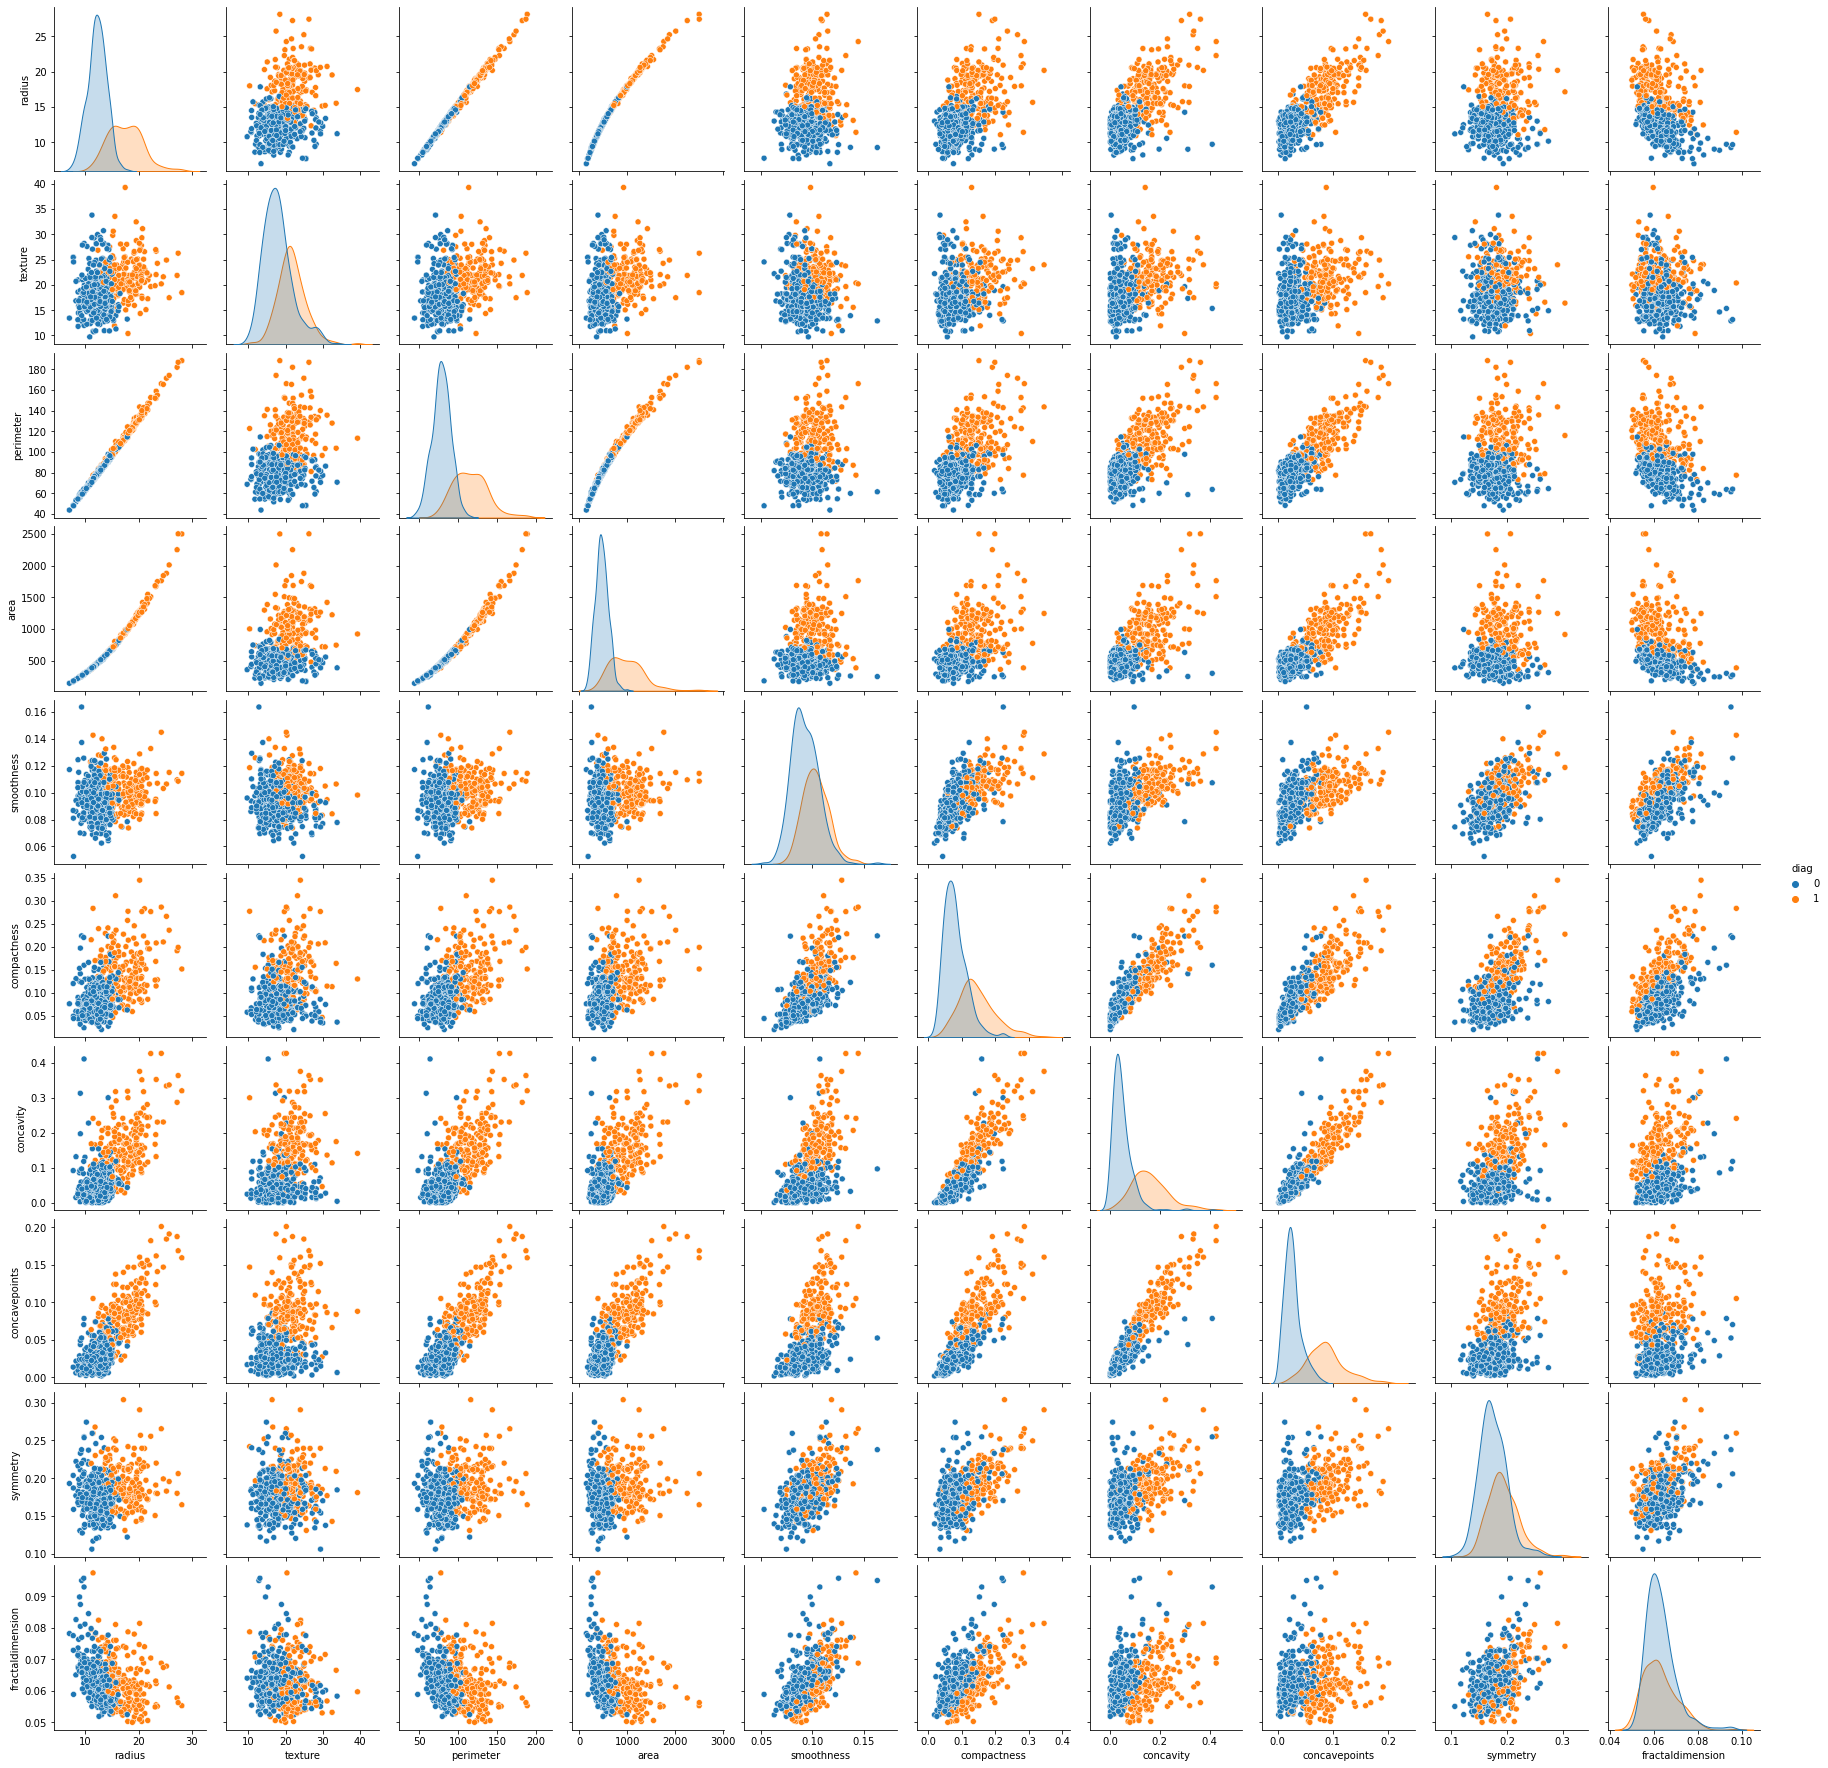

In [13]:
sb.pairplot(base, hue="diag", hue_order=None, palette=None, vars=None, x_vars=None,
            y_vars=None, kind='scatter', diag_kind='auto', markers=None, height=2.5)


## 1c. Descripción de la base de datos

- A) Estadísticas descriptivas: Un análisis inicial deja observar que hay 569 observaciones para 12 variables diferentes. Para la variable diagnosis tenemos una variable dummy que toma la letra M como maligno y la letra B como benigno. Eventualmente, esta variable la convertimos en una dummy que toma el valor de 1 para maligno y 0 para benigno. Por otra parte, podemos observar que las variables radius, texture, perimeter y area toman valores superiores a 1 mientras que las demás variables están por debajo de este valor. De igual manera, se puede observar que las variables que tienen una menor desviación estándar son: radius, texture, perimeter, smoothness, concavepoints y symmetry lo que permite afirmar hasta cierto punto que los valores de estas variables son más compactos. Por otra parte, luego de realizar un histograma para la variable diagnosis se puede apreciar que hay un total de 212 diagnósticos con tumor maligno y 357 con tumor benigno. Finalmente, se puede observar que concavity y concavepoints tienen 13 missing values para cada una de sus respectivas variables.

- B) Luego de realizar un Pairplot, surgen algunas observaciones interesantes para observar la relación de las diferentes variables con respecto a la variable que queremos predecir. Para la variable radius se puede observar que entre mayor sea el radio del tumor, mayor será la probabilidad de que el tumor sea maligno y este mismo caso se repite para perimeter, area y concavepoints. No obstante, cabe aclarar que esta es solo una observación preliminar y no necesariamente significa que este siempre sea el caso. Otra observación interesante de este Pairplot es que las variables radius y perimeter tienen una correlación bastante positiva, lo que, en cierto modo, permite predecir que entre mayor sea el radio y el perímetro, mayor será la probabilidad de que el tumor sea maligno. Para las demás variables, se logra observar cierta correlación positiva, aunque, esta en realidad no sea tan evidente y fácil de llegar a esa conclusión pues se observa una mayor dispersión en cuanto a los valores.


# 2. Estandarización e Imputación

#### Pre-procesamiento 

In [14]:
X = base.drop(columns = ["diag"])
y = base["diag"]
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, 
    random_state = 666, stratify = y) #Stratify se usa para que en la muestra de entrenamiento y prueba se conserve la distribución de la variable diagnosis. Le da mas claridad al modelo
# Se va a tomar el 30% de la muestra como test


In [15]:
#Se definen las columnas que contienen variables numéricas para separarlas de las categoricas
X_train.select_dtypes(include=np.number).columns


Index(['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
       'concavity', 'concavepoints', 'symmetry', 'fractaldimension'],
      dtype='object')

#### Recetas

- 1. Variables númericas van a ser escaladas 
- 2. Variables categoricas van a ser dummyficadas
- Para ambas se van a imputar missing values

In [16]:
#Normalizamos las variables numéricas para que el algorítmo procese de una mejor manera los datos con media 0 y varianza constante
numeric_variables = X_train.select_dtypes(include=np.number).columns.to_list() #Selecciona las variables numéricas con las que son numericas

numeric_scaler = ('scaler', StandardScaler())


In [17]:
# Se van a imputar los datos faltantes usando KNN y se van a asumir 21 vecinos más cercanos para el imputador, tiene que ser un numero impar. 
numeric_imputer = ('knn_imputer', KNNImputer(n_neighbors = 21))

In [18]:
#Se construye el pipeline con los argumentos que calculamos antes, el escalador y el imputador, para darle la secuencia de pasos.
numeric_transformer = Pipeline(steps=[numeric_scaler, numeric_imputer])


In [19]:
categorical_variables = X_train.select_dtypes(
    exclude=np.number).columns.to_list() #Define las variables categóricas excluyendo las numericas 
categorical_imputer = ('mode_imputer', SimpleImputer(
    missing_values=np.nan, strategy='most_frequent')) 

#Dado que no hay variables dummies en las explicativas no se deben eliminar columnas, ni variables dummies por posibles problemas de multicolinealidad.

- Sin embargo si se deben dummificar las variables categóricas, para eso se debe usar la siguiente libreria:

In [20]:
categorical_dummy = ('dummyficar', OneHotEncoder(drop = "first")) #Esto va a dummificar a las variables para poder procesarlas en el pipeline
categorical_transformer=Pipeline(steps=[categorical_imputer,categorical_dummy]) #Va a imputar y dummificar las variables categoricas.

In [21]:
preprocessor = ColumnTransformer(transformers = [
    ('numeric', numeric_transformer, numeric_variables),
    ('categorical', categorical_transformer, categorical_variables)
    ])
#Una vez se tiene este preprocesador las variables ya están estandarizadas e imputadas(no tienen missing values)

# 3. Implementar modelos de Machine Learning

#### 3a. Vecinos Más Cercanos (K-NN)

In [22]:

#Definimos el modelo KNN
modelo_knn=KNeighborsClassifier()

#Definimos un pipeline para los pasos que va a tomar:

pipeline_knn=Pipeline(steps=[("preprocesador",preprocessor),("clasificador",modelo_knn)])

In [23]:
#Se definen los distintos algorítmos con los que el modelo va a trabajar


#Se define una grilla de parámtros optimos para el odelo
param_grid = {'clasificador__n_neighbors': list(range(3,100,2)),}


In [24]:
KNN_CV = GridSearchCV(pipeline_knn, param_grid, scoring='accuracy',
                      cv=5, n_jobs=-1, return_train_score=True)


In [25]:
#Se aplica el modelo a los datos
KNN_CV.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesador',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('knn_imputer',
                                                                                          KNNImputer(n_neighbors=21))]),
                                                                         ['radius',
                                                                          'texture',
                                                                          'perimeter',
                                                                          'area',
                                                                   

In [26]:
#Revisamos el # de vecinos más cercanos
KNN_CV.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('knn_imputer',
                                                                   KNNImputer(n_neighbors=21))]),
                                                  ['radius', 'texture',
                                                   'perimeter', 'area',
                                                   'smoothness', 'compactness',
                                                   'concavity', 'concavepoints',
                                                   'symmetry',
                                                   'fractaldimension']),
                                                 ('categorical',
                   

- Según lo anterior se deberían usar 19 vecinos más cercanos para el modelo

#### Evaluacion del modelo de KNN

In [27]:
#Queremos ver como le fue al modelo tanto dentro, como fuera de muestra
knn_y_hat_in=KNN_CV.predict(X_train)
knn_y_hat_out=KNN_CV.predict(x_test)
knn_y_hat_out_prob=KNN_CV.predict_proba(x_test)[:,1]
knn_y_hat_in_prob=KNN_CV.predict_proba(X_train)[:,1]

In [28]:
knn_ac_out=accuracy_score(y_test,knn_y_hat_out)
knn_pr_out=precision_score(y_test,knn_y_hat_out)
knn_rs_out=recall_score(y_test,knn_y_hat_out)
knn_auc_out=roc_auc_score(y_test,knn_y_hat_out_prob)
knn_resultados_out=pd.DataFrame({
                                "Modelo":"Vecinos mas Cercanos",
                                "Accuracy":knn_ac_out,
                                "Precision":knn_pr_out,
                                "Recall":knn_rs_out,
                                "AUC":knn_auc_out},
                                index=[0]
)

In [29]:
knn_resultados_out

,Modelo,Accuracy,Precision,Recall,AUC
0,Vecinos mas Cercanos,0.947368,0.966102,0.890625,0.994597


In [30]:
knn_ac_in=accuracy_score(y_train,knn_y_hat_in)
knn_pr_in=precision_score(y_train,knn_y_hat_in)
knn_rs_in=recall_score(y_train,knn_y_hat_in)
knn_auc_in=roc_auc_score(y_train,knn_y_hat_in_prob)
knn_resultados_in = pd.DataFrame({
    "Modelo": "Vecinos Mas Cercanos",
                                "Accuracy": knn_ac_in,
                                "Precision": knn_pr_in,
                                "Recall": knn_rs_in,
                                "AUC": knn_auc_in},
                                index=[0]
                                )


In [31]:
knn_resultados_in

,Modelo,Accuracy,Precision,Recall,AUC
0,Vecinos Mas Cercanos,0.939698,0.969697,0.864865,0.985014


#### 3b. Modelo de Árbol

In [32]:
# Se construye el modelo
from sklearn.tree import DecisionTreeClassifier

model_dt = tree.DecisionTreeClassifier(random_state=666)
    
pipeline_dt=Pipeline(steps=[("preprocesador",preprocessor),("clasificador",model_dt)])

search_space_dt=[{
    'clasificador__max_depth':[3,5,8,15,25,30],
    'clasificador__min_samples_leaf':[1,2,3,5,10,15,20,30],
}]


In [33]:
dt_cv=GridSearchCV(pipeline_dt,search_space_dt,scoring="accuracy",cv=5,n_jobs=-1) #se definió que use el pipeline de rf, se definieron los parámetros para calibrar el modelo de rf se le pidió que valore más accuracy, y se van a  hacer 5 cross validations

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesador',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('knn_imputer',
                                                                                          KNNImputer(n_neighbors=21))]),
                                                                         ['radius',
                                                                          'texture',
                                                                          'perimeter',
                                                                          'area',
                                                                   

In [35]:
dt_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesador',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('knn_imputer',
                                                                                          KNNImputer(n_neighbors=21))]),
                                                                         ['radius',
                                                                          'texture',
                                                                          'perimeter',
                                                                          'area',
                                                                   

In [76]:
dt_cv.best_params_

{'clasificador__max_depth': 3, 'clasificador__min_samples_leaf': 1}

In [78]:
pd.DataFrame(dt_cv.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clasificador__max_depth,param_clasificador__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025201,0.008270,0.019852,0.014365,3,1,"{'clasificador__max_depth': 3, 'clasificador__...",0.9250,0.9375,1.0000,0.911392,0.949367,0.944652,0.030428,1
1,0.033522,0.007592,0.015417,0.003368,3,2,"{'clasificador__max_depth': 3, 'clasificador__...",0.9250,0.9375,1.0000,0.911392,0.949367,0.944652,0.030428,1
2,0.031593,0.008202,0.010725,0.002597,3,3,"{'clasificador__max_depth': 3, 'clasificador__...",0.9250,0.9375,0.9875,0.911392,0.949367,0.942152,0.025963,3
3,0.032527,0.011634,0.010422,0.002719,3,5,"{'clasificador__max_depth': 3, 'clasificador__...",0.9250,0.9250,0.9875,0.898734,0.936709,0.934589,0.029235,7
4,0.034608,0.010635,0.019802,0.011076,3,10,"{'clasificador__max_depth': 3, 'clasificador__...",0.9250,0.9125,0.9375,0.860759,0.936709,0.914494,0.028371,30
5,0.029193,0.018323,0.010671,0.003709,3,15,"{'clasificador__max_depth': 3, 'clasificador__...",0.8625,0.9250,0.9000,0.860759,0.924051,0.894462,0.028271,31
6,0.023667,0.009739,0.009228,0.001764,3,20,"{'clasificador__max_depth': 3, 'clasificador__...",0.8625,0.9250,0.9125,0.822785,0.911392,0.886835,0.038504,43
7,0.020813,0.005577,0.013619,0.007856,3,30,"{'clasificador__max_depth': 3, 'clasificador__...",0.8625,0.9250,0.9125,0.835443,0.911392,0.889367,0.034408,37
8,0.022961,0.002680,0.010390,0.002334,5,1,"{'clasificador__max_depth': 5, 'clasificador__...",0.9250,0.9500,0.9750,0.886076,0.962025,0.939620,0.031439,4
9,0.022632,0.004556,0.008775,0.000757,5,2,"{'clasificador__max_depth': 5, 'clasificador__...",0.9250,0.9500,0.9625,0.898734,0.949367,0.937120,0.022717,6


- En este caso, nos dice que la máxima profundidad del arbol debe ser 3
- El número de hojas mínimo debe ser, no se porque no se arroja el parámetro de las hojas, sin embargo está incluido en el modelo

#### Predicciones CART

In [37]:
#Queremos ver como le fue al modelo tanto dentro, como fuera de muestra
dt_y_hat_in=dt_cv.predict(X_train)
dt_y_hat_out=dt_cv.predict(x_test)
dt_y_hat_out_prob=dt_cv.predict_proba(x_test)[:,1]
dt_y_hat_in_prob=dt_cv.predict_proba(X_train)[:,1]

In [38]:
dt_ac_out=accuracy_score(y_test,dt_y_hat_out)
dt_pr_out=precision_score(y_test,dt_y_hat_out)
dt_rs_out=recall_score(y_test,dt_y_hat_out)
dt_auc_out=roc_auc_score(y_test,dt_y_hat_out_prob)
dt_resultados_out=pd.DataFrame({
                                "Modelo":"RandomForest",
                                "Accuracy":dt_ac_out,
                                "Precision":dt_pr_out,
                                "Recall":dt_rs_out,
                                "AUC":dt_auc_out},
                                index=[0]
)

In [39]:
dt_resultados_out

,Modelo,Accuracy,Precision,Recall,AUC
0,RandomForest,0.929825,0.948276,0.859375,0.933557


In [40]:
dt_ac_in=accuracy_score(y_test,dt_y_hat_out)
dt_pr_in=precision_score(y_test,dt_y_hat_out)
dt_rs_in=recall_score(y_test,dt_y_hat_out)
dt_auc_in=roc_auc_score(y_test,dt_y_hat_out_prob)
dt_resultados_in=pd.DataFrame({
                                "Modelo":"RandomForest",
                                "Accuracy":dt_ac_in,
                                "Precision":dt_pr_in,
                                "Recall":dt_rs_in,
                                "AUC":dt_auc_in},
                                index=[0]
)

In [41]:
dt_resultados_in

,Modelo,Accuracy,Precision,Recall,AUC
0,RandomForest,0.929825,0.948276,0.859375,0.933557


#### 3c. Random Forest 

In [42]:
# Se va a importar la libreria para hacer el random forest:

modelo_rf=RandomForestClassifier(n_jobs=-2,random_state=666)


In [43]:
search_space_rf=[{
#    'clasificador__n_estimators':[100,300,500,800,1200],
    'clasificador__max_depth':[3,5,8,15,25,30],
#    'clasificador__min_samples_split':[2,5,10,15,100],
    'clasificador__min_samples_leaf':[1,2,5,10],
}]

In [44]:
#Se va a crear un pipeline para incluir el preprocesador de los datos que usamos antes y el modelo de randomforest que definimos como modelo

pipeline_rf=Pipeline(steps=[("preprocesor",preprocessor),
                            ("clasificador",modelo_rf)
])


In [45]:
# Se va a hacer cross-validation para el modelo de Random forest

rf_cv=GridSearchCV(pipeline_rf,search_space_rf,scoring="accuracy",cv=5,n_jobs=-1) #se definió que use el pipeline de rf, se definieron los parámetros para calibrar el modelo de rf se le pidió que valore más accuracy, y se van a  hacer 5 cross validations

In [46]:
#Se va a aplicar el modelo de random forest al modelo de train
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('knn_imputer',
                                                                                          KNNImputer(n_neighbors=21))]),
                                                                         ['radius',
                                                                          'texture',
                                                                          'perimeter',
                                                                          'area',
                                                                     

- Para obtener los mejores híper-parametros del modelo:

In [47]:
rf_cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocesor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('knn_imputer',
                                                                   KNNImputer(n_neighbors=21))]),
                                                  ['radius', 'texture',
                                                   'perimeter', 'area',
                                                   'smoothness', 'compactness',
                                                   'concavity', 'concavepoints',
                                                   'symmetry',
                                                   'fractaldimension']),
                                                 ('categorical',
                     

- Nos dice que: el max_depth debe ser 15


In [48]:
#Queremos ver como le fue al modelo tanto dentro, como fuera de muestra
rf_y_hat_in=rf_cv.predict(X_train)
rf_y_hat_out=rf_cv.predict(x_test)
rf_y_hat_out_prob=rf_cv.predict_proba(x_test)[:,1]
rf_y_hat_in_prob=rf_cv.predict_proba(X_train)[:,1]

#### Evaluamos las métricas de Random Forest

In [49]:
rf_ac_out=accuracy_score(y_test,rf_y_hat_out)
rf_pr_out=precision_score(y_test,rf_y_hat_out)
rf_rs_out=recall_score(y_test,rf_y_hat_out)
rf_auc_out=roc_auc_score(y_test,rf_y_hat_out_prob)
rf_resultados_out=pd.DataFrame({
                                "Modelo":"RandomForest",
                                "Accuracy":rf_ac_out,
                                "Precision":rf_pr_out,
                                "Recall":rf_rs_out,
                                "AUC":rf_auc_out},
                                index=[0]
)

In [50]:
rf_resultados_out

,Modelo,Accuracy,Precision,Recall,AUC
0,RandomForest,0.959064,0.952381,0.9375,0.995035


- Los resultados anteriores, son los resultados fuera de Base del modelo

In [51]:
rf_ac_in=accuracy_score(y_train,rf_y_hat_in)
rf_pr_in=precision_score(y_train,rf_y_hat_in)
rf_rs_in=recall_score(y_train,rf_y_hat_in)
rf_auc_in=roc_auc_score(y_train,rf_y_hat_in_prob)
rf_resultados_in = pd.DataFrame({
    "Modelo": "RandomForest",
                                "Accuracy": rf_ac_in,
                                "Precision": rf_pr_in,
                                "Recall": rf_rs_in,
                                "AUC": rf_auc_in},
                                index=[0]
                                )


In [52]:
rf_resultados_in

,Modelo,Accuracy,Precision,Recall,AUC
0,RandomForest,1.0,1.0,1.0,1.0


- Los resultados dentro de muestra son perfectos, predice al 100% dentro de muestra

#### 3d. Regresión logísitica

In [53]:

lr = LogisticRegression(penalty="l1", solver='liblinear', random_state=666) #Se define la regresión logística, en este caso se usa lasso específicado con el parámtro l1. Ver código arriba para ver como se encontró el hiper parámetro. 


In [54]:
#Vamos a correr el modelo con cross validation ya que hicimos el preprocesamiento

pipeline = Pipeline(steps = [
        ('preprocess', preprocessor),
        ('classifier', lr)
    ])

#Buscamos el parámetro c óptimo para la regresion de lasso
search_space_lasso = [{
    'classifier__C': np.linspace(0.01, 1, 100),}]


cv_lasso = GridSearchCV(pipeline, search_space_lasso, scoring = "accuracy", cv = 5, n_jobs = -1, verbose = 0)



In [55]:
cv_lasso = cv_lasso.fit(X_train, y_train)

- Buscamos los mejores parámetros de la regresión Lasso

In [56]:
cv_lasso.best_params_

{'classifier__C': 0.14}

- Nos dice que el Clasificador óptimo debe ser .14, c=.14

#### Clasificacion de la Regresión Lasso

In [57]:
#Se hace la prediccion del modelo dentro y fuera de muestra.

lr_y_hat_in=cv_lasso.predict(X_train)
lr_y_hat_out=cv_lasso.predict(x_test)
lr_y_hat_out_prob=cv_lasso.predict_proba(x_test)[:,1]
lr_y_hat_in_prob=cv_lasso.predict_proba(X_train)[:,1]

In [58]:
lr_ac_out=accuracy_score(y_test,lr_y_hat_out)
lr_pr_out=precision_score(y_test,lr_y_hat_out)
lr_rs_out=recall_score(y_test,lr_y_hat_out)
lr_auc_out=roc_auc_score(y_test,lr_y_hat_out_prob)
lr_resultados_out=pd.DataFrame({
                                "Modelo":"Regresión de Lasso",
                                "Accuracy":lr_ac_out,
                                "Precision":lr_pr_out,
                                "Recall":lr_rs_out,
                                "AUC":lr_auc_out},
                                index=[0]
)

In [59]:
lr_resultados_out

,Modelo,Accuracy,Precision,Recall,AUC
0,Regresión de Lasso,0.964912,0.967742,0.9375,0.994305


In [60]:
lr_ac_in=accuracy_score(y_train,lr_y_hat_in)
lr_pr_in=precision_score(y_train,lr_y_hat_in)
lr_rs_in=recall_score(y_train,lr_y_hat_in)
lr_auc_in=roc_auc_score(y_train,lr_y_hat_in_prob)
lr_resultados_in=pd.DataFrame({
                                "Modelo":"Regresión de Lasso",
                                "Accuracy":lr_ac_in,
                                "Precision":lr_pr_in,
                                "Recall":lr_rs_in,
                                "AUC":lr_auc_in},
                                index=[0]
)

In [61]:
lr_resultados_in

,Modelo,Accuracy,Precision,Recall,AUC
0,Regresión de Lasso,0.929648,0.934783,0.871622,0.981919


# 4. Calibración, Computar el MSE, Graficar la Curva ROC

#### 1. Regresión Lasso

In [62]:
from sklearn.calibration import calibration_curve
probs = lr_y_hat_out_prob
lr_prob_true, lr_prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(lr_prob_true)
print(lr_prob_pred)

[0.         0.2        0.625      0.90909091 1.        ]
[0.05752035 0.29182782 0.51411584 0.69932195 0.96472957]


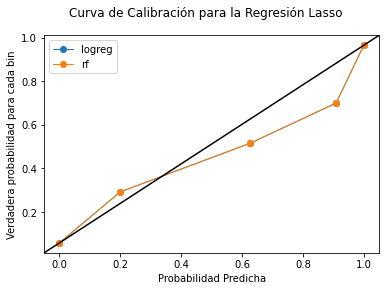

In [63]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(lr_prob_true,lr_prob_pred, marker='o', linewidth=1, label='logreg')
plt.plot(lr_prob_true, lr_prob_pred, marker='o', linewidth=1, label='rf')

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Curva de Calibración para la Regresión Lasso')
ax.set_xlabel('Probabilidad Predicha')
ax.set_ylabel('Verdadera probabilidad para cada bin')
plt.legend()
plt.show()

#### 2. Random Forest

In [64]:
from sklearn.calibration import calibration_curve
probs = rf_y_hat_out_prob
rf_prob_true, rf_prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(rf_prob_true)
print(rf_prob_pred)

[0.         0.375      0.5        0.88888889 1.        ]
[0.02721649 0.2925     0.53125    0.73777778 0.97591837]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


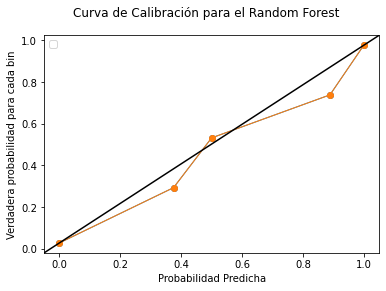

In [65]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(rf_prob_true,rf_prob_pred, marker='o', linewidth=1)
plt.plot(rf_prob_true, rf_prob_pred, marker='o', linewidth=1)

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Curva de Calibración para el Random Forest')
ax.set_xlabel('Probabilidad Predicha')
ax.set_ylabel('Verdadera probabilidad para cada bin')
plt.legend()
plt.show()

scores = rf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, scores, n_bins=20)

#### 3. Vecinos más cercanos

In [66]:
probs = knn_y_hat_out_prob
knn_prob_true, knn_prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(lr_prob_true)
print(lr_prob_pred)

[0.         0.2        0.625      0.90909091 1.        ]
[0.05752035 0.29182782 0.51411584 0.69932195 0.96472957]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


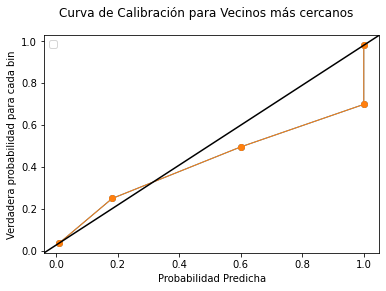

In [67]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(knn_prob_true,knn_prob_pred, marker='o', linewidth=1)
plt.plot(knn_prob_true, knn_prob_pred, marker='o', linewidth=1)

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Curva de Calibración para Vecinos más cercanos')
ax.set_xlabel('Probabilidad Predicha')
ax.set_ylabel('Verdadera probabilidad para cada bin')
plt.legend()
plt.show()

#### 4. Árbol CART

In [68]:
probs = dt_y_hat_out_prob
dt_prob_true, dt_prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(lr_prob_true)
print(lr_prob_pred)

[0.         0.2        0.625      0.90909091 1.        ]
[0.05752035 0.29182782 0.51411584 0.69932195 0.96472957]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


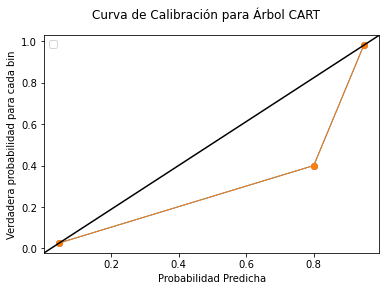

In [69]:
fig, ax = plt.subplots()
# only these two lines are calibration curves
plt.plot(dt_prob_true,dt_prob_pred, marker='o', linewidth=1)
plt.plot(dt_prob_true,dt_prob_pred, marker='o', linewidth=1)

line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Curva de Calibración para Árbol CART')
ax.set_xlabel('Probabilidad Predicha')
ax.set_ylabel('Verdadera probabilidad para cada bin')
plt.legend()
plt.show()

## 4b. Computar el MSE

#### Predicciones sobre la muestra de prueba (test)

In [70]:
print(lr_resultados_out)
print(knn_resultados_out)
print(rf_resultados_out)
print (dt_resultados_out)

               Modelo  Accuracy  Precision  Recall       AUC
0  Regresión de Lasso  0.964912   0.967742  0.9375  0.994305
                 Modelo  Accuracy  Precision    Recall       AUC
0  Vecinos mas Cercanos  0.947368   0.966102  0.890625  0.994597
         Modelo  Accuracy  Precision  Recall       AUC
0  RandomForest  0.959064   0.952381  0.9375  0.995035
         Modelo  Accuracy  Precision    Recall       AUC
0  RandomForest  0.929825   0.948276  0.859375  0.933557


## 4c. Curva ROC

#### Para los resultados fuera de base, es decir las predicciones que se hicieron sobre la muestra test

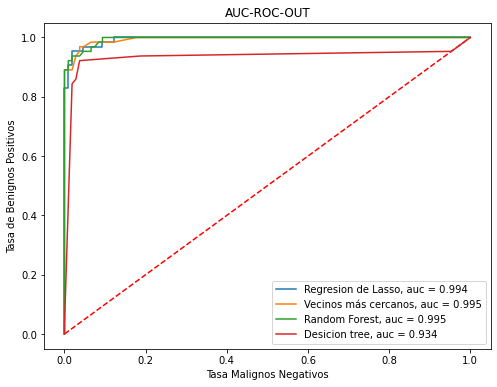

In [71]:

#Se definen los parámetros del gráfico
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

#Creamos la Curva ROC para la regresión de lasso
pred_lr = lr_y_hat_out_prob

fpr, tpr,_= metrics.roc_curve(y_test, pred_lr)
auc = metrics.roc_auc_score(y_test, pred_lr)
plt.plot(fpr, tpr, label=f'Regresion de Lasso, auc = {str(round(auc,3))}')

#Creamos la Curva ROC para Vecinos mas Cercanos
pred_knn = knn_y_hat_out_prob
fpr, tpr,_ = metrics.roc_curve(y_test, pred_knn)
auc = metrics.roc_auc_score(y_test, pred_knn)

plt.plot(fpr, tpr, label=f'Vecinos más cercanos, auc = {str(round(auc,3))}')

#Creamos la curva ROC para Random Forest
pred_rf = rf_y_hat_out_prob
fpr, tpr, _ = metrics.roc_curve(y_test, pred_rf)
auc = metrics.roc_auc_score(y_test, pred_rf)
plt.plot(fpr, tpr, label=f'Random Forest, auc = {str(round(auc,3))}')

#Curva ROC para el CART
pred_dt = dt_y_hat_out_prob
fpr, tpr, _ = metrics.roc_curve(y_test, pred_dt)
auc = metrics.roc_auc_score(y_test, pred_dt)
plt.plot(fpr, tpr, label=f'Desicion tree, auc = {str(round(auc,3))}')



#Creamos la Curva ROC para Desicion Tree

plt.ylabel("Tasa de Benignos Positivos")
plt.xlabel("Tasa Malignos Negativos")
plt.title("AUC-ROC-OUT")
plt.legend()
plt.show()

#### Resultados para los valores dentro de muestra

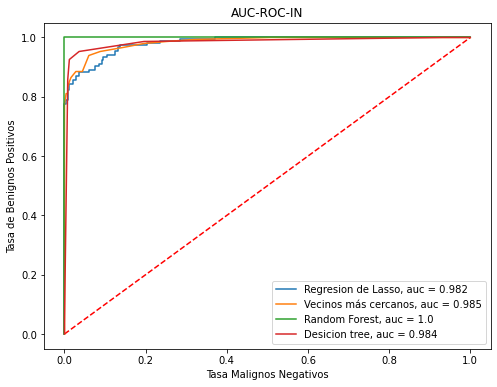

In [72]:

#Se definen los parámetros del gráfico
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1],'r--')

#Creamos la Curva ROC para la regresión de lasso
pred_lr = lr_y_hat_in_prob

fpr, tpr,_= metrics.roc_curve(y_train, pred_lr)
auc = metrics.roc_auc_score(y_train, pred_lr)
plt.plot(fpr, tpr, label=f'Regresion de Lasso, auc = {str(round(auc,3))}')

#Creamos la Curva ROC para Vecinos mas Cercanos
pred_knn = knn_y_hat_in_prob
fpr, tpr,_ = metrics.roc_curve(y_train, pred_knn)
auc = metrics.roc_auc_score(y_train, pred_knn)

plt.plot(fpr, tpr, label=f'Vecinos más cercanos, auc = {str(round(auc,3))}')

#Creamos la curva ROC para Random Forest
pred_rf = rf_y_hat_in_prob
fpr, tpr, _ = metrics.roc_curve(y_train, pred_rf)
auc = metrics.roc_auc_score(y_train, pred_rf)
plt.plot(fpr, tpr, label=f'Random Forest, auc = {str(round(auc,3))}')

#Curva ROC para el CART
pred_dt = dt_y_hat_in_prob
fpr, tpr, _ = metrics.roc_curve(y_train, pred_dt)
auc = metrics.roc_auc_score(y_train, pred_dt)
plt.plot(fpr, tpr, label=f'Desicion tree, auc = {str(round(auc,3))}')



#Creamos la Curva ROC para Desicion Tree

plt.ylabel("Tasa de Benignos Positivos")
plt.xlabel("Tasa Malignos Negativos")
plt.title("AUC-ROC-IN")
plt.legend()
plt.show()

# 5. Comparación basada en el Punto anterior

De los resultados anteirores se identifica lo siguiente: 
- Dado el criterio de calibracion todos los modelos tienden a infravolar sus probabilidades cuando estas sobrepasan el 0.4. SIn embargo el modelo que más se aproxima a la curva de calibración es el estimado por el método de Random Forest
- Dado los resultados de accuracy, precision, recall, AUC y MSE el modelo que mejor se aproxima a los resultados es la regression de Lasso, esto podr'ia ser que al implementar el castigo a los estimadores se seleccionan lo que son estricatamente necesarios. 
- Por último, de la curva ROC para la predicción muestra que tanto Lasso, Vecinos más cercanos y Random Forest son los mejores modelos y para los valores de la muestra se encuentra que la metodología de Random Forest est perfecta. 

Despues de evaluar los cuatro modelos y hacer diferentes pruebas es posible concluir que el mejor modelo implementado es Random Forest